# Overview of collected data

In this notebook, files will be generated that include information on how many PSMs (all and significant ones), peptides and proteins that are identified with ionbot <br>
Also some new data is prepared to be included in the database with the database_parser.ipynb notebook


Some notes on what the annotation files contain:
- assays_not_found.csv: contains the assays that were not present on the compomics server at the time when ionbot results were put in the database
- ionbot_assays.log: log file containing information on which assays proteins could be extracted and which ones were empty or no PSM reached larger confidence than 0.01 q-value
- parser_failed_ae4.csv: related to ionbot_assays.log. Contains the filenames of the assays that could not be parsed with the ionbot_parser function
- new_assay_file_paths.csv: the assays in assays_not_found.csv were on 13/02/2023 once again searched on the compomics server and the filepaths are added
- parser_tested_new_files.csv: contains information on which files can be parsed with the ionbot_parser function. This will be overwritten later with information on PSM peptide and protein information
- pooling.log: contains annotation on the fractions of the samples that were previously added to the mySQL database

These files will need to be reformatted to enhance clarity

In [1]:
import pandas as pd
import mysql.connector
import glob

from ipywidgets import IntProgress
from IPython.display import display

In [20]:
# Check for which the ionbot parser fails

# I need PSMs before and after filtering, identify tryptic peptides and protein amounts

def ionbot_parse(file):
    '''Returns [nPSMsBefore, nPSMsAfter ,nPeptides, nProteins] for the given file'''

    nPSMsBefore = 0
    nPSMsAfter = 0
    nPeptides = 0
    nProteins = 0
    
    version = file.split("/")[8]

    df = pd.read_csv(file, sep=',')
        
    if df.empty:
        return [nPSMsBefore, nPSMsAfter ,nPeptides, nProteins]

    nPSMsBefore = df.shape[0]
    # best_psm is equal to 1
    df = df.loc[df['best_psm'] == 1]
    #  q-value-best <= 0.01
    df = df.loc[df['q_value'] <= 0.01]
    # DB column needs to contain 'T' (otherwise decoy hit) +  extra check: only retain swissprot entries (start with sp)
    df = df.loc[df['DB'] == 'T']

    nPSMsAfter = df.shape[0]

    if df.empty:    
        return [nPSMsBefore, nPSMsAfter, nPeptides, nProteins]

    #Only supports versions 
    versions = "IONBOT_v0.6.2 IONBOT_v0.6.3 IONBOT_v0.7.0 IONBOT_v0.8.0".split()
    if version not in versions:
        print(version, "not supported!")
        return False

    if version in ["IONBOT_v0.6.2", "IONBOT_v0.6.3"]:

        df_validated = df[df['proteins'].astype(str).str.startswith('sp')]
        # remove peptides that are not uniquely identified and are linked to multiple proteins = containing || in proteins
        x = '||'
        # regex is False otherwise it also detects a single | which is in every protein present
        df_validated = df_validated[~df_validated['proteins'].str.contains(x, regex=False)]
        #Reformat proteins to uniprotID

        if df_validated.empty:
    
            return [nPSMsBefore, nPSMsAfter ,nPeptides, nProteins]

        df_validated["proteins"] = df_validated.apply(lambda x: x["proteins"].split('|')[1], axis = 1)
        
    elif version in ["IONBOT_v0.7.0", "IONBOT_v0.8.0"]:
        x = "||"
        df_validated = df[~df['proteins'].str.contains(x, regex = False)]

        if df_validated.empty:
            
            return [nPSMsBefore, nPSMsAfter ,nPeptides, nProteins]

        df_validated["proteins"] = df_validated.apply(lambda x: dbf.id_regex(x["proteins"]), axis = 1)
        df_validated = df_validated[df_validated["proteins"].notna()]

    # check not all entries were removed
    if df_validated.empty:
        return [nPSMsBefore, nPSMsAfter ,nPeptides, nProteins]
        
    # modifications can be linked to unimod id: peptide_modifications: unimod ID vs peptide
    # calculte the spectral counts from each peptide: dict: count
    
    peptides = df_validated['matched_peptide'].tolist()

    nPeptides = len(peptides)
    nProteins = len(df_validated.proteins.unique())

    

    return [nPSMsBefore, nPSMsAfter ,nPeptides, nProteins]

In [2]:
import master_functions as mf
dbf = mf.dbf()

connection succesfull


In [3]:
conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

connection succesfull


In [5]:
assay_project_query = "SELECT * FROM assay"
assay_project_data = pd.read_sql_query(assay_project_query, conn)

project_query = "SELECT project_id, PXD_accession FROM project"
project_data = pd.read_sql_query(project_query, conn)

assay_cell_query = "SELECT assay_id, cell_id FROM cell_to_assay"
assay_cell_data = pd.read_sql_query(assay_cell_query, conn)

cell_query = "SELECT * FROM cell"
cell_data = pd.read_sql_query(cell_query, conn)

full_df = pd.merge(assay_project_data, assay_cell_data, on = "assay_id")
full_df = pd.merge(full_df, cell_data, on = "cell_id")
full_df = pd.merge(full_df, project_data, on = "project_id")

In [6]:
# The assays and linked metadata that are loaded in the sql database
print(full_df.shape)
full_df.head()

(3152, 11)


,assay_id,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession
0,30960,1815,3B10-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533
1,30961,1815,3B10-2,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533
2,30962,1815,3B1-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533
3,30963,1815,3B11-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533
4,30964,1815,3B11-2,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533


Date 13/02/2023. The dataset will be updated if new projects and files are reprocessed and available on the compomics server.

Unreprocessed projects taken from 'database_parser.ipynb'. <br>
The previously not found assays on the compomics drive are stored in a file called **assays_not_found.csv** <br>
The samples with empty ionbot results file or no identifications with q-value < .05 are stored in **parser_failed_ae4.csv**

1. projects

In [16]:
unprocessed_pxds = ['PXD001592', 'PXD010012', 'PXD010256', 'PXD011580', 'PXD000071', 'PXD018625', 'PXD001305', 'PXD014777', 'PXD002572', 'PXD018450']

assays_not_found = pd.read_csv('assays_not_found.csv', sep = ',')

empty_files = pd.read_csv('parser_failed_ae4.csv')

In [17]:
# Checking if projects are already loaded in the database
already_loaded_projects = dbf.check_new_project(['PXD001592', 'PXD010012', 'PXD010256', 'PXD011580', 'PXD000071', 'PXD018625', 'PXD001305', 'PXD014777', 'PXD002572', 'PXD018450'])
print(already_loaded_projects, 'are already imported in the database.')

# Checking if the projects are ofund on the compomics server and if so, how many assays are in that folder
pxd_found, file_output, version_path = dbf.find_pxd_path(['PXD001592', 'PXD010012', 'PXD010256', 'PXD011580', 'PXD000071', 'PXD018625', 'PXD001305', 'PXD014777', 'PXD002572', 'PXD018450'], True)
print(file_output)

Projects checked.
[] are already imported in the database.
Found 10 out of 10.
{'/home/compomics/mounts/conode53/pride2/PRIDE_DATA/PXD001592': 0, '/home/compomics/mounts/conode54/pride/PRIDE_DATA/PXD010012': 0, '/home/compomics/mounts/conode54/pride/PRIDE_DATA/PXD010256': 0, '/home/compomics/mounts/conode54/pride/PRIDE_DATA/PXD011580': 0, '/home/compomics/mounts/conode55/pride/PRIDE_DATA/PXD000071': 0, '/home/compomics/mounts/conode55/pride/PRIDE_DATA/PXD018625': 0, '/home/compomics/mounts/conode55/pride/PRIDE_DATA/PXD001305': 0, '/home/compomics/mounts/conode55/pride/PRIDE_DATA/PXD014777': 0, '/home/compomics/mounts/conode55/pride/PRIDE_DATA/PXD002572': 0, '/home/compomics/mounts/conode55/pride/PRIDE_DATA/PXD018450': 187}


Only PXD018450 is newly added. This is added through scripts written in ./Metadata/check_PXD_reprocessed.ipynb

2. assays

Part 1: Files not found in the compomics database

In [18]:
assays_not_found
assays_not_found["file_path"] = assays_not_found.apply(lambda x: dbf.find_file_path(x["PXD"], x["RAW"]), axis = 1)

In [19]:
assays_not_found[assays_not_found.file_path.notna()]

,PXD,RAW,Useable,cell_line,disease,tissue_type,treatment,sub_cell,pool_id,file_path
0,PXD000612,20120203_EXQ5_KiSh_SA_LabelFree_HeLa_Proteome_...,yes,HeLa,adenocarcinoma,cervix,Nocodazole,HeLa S3,7,/home/compomics/mounts/conode53/pride/PRIDE_DA...
1,PXD000612,20120203_EXQ5_KiSh_SA_LabelFree_HeLa_Proteome_...,yes,HeLa,adenocarcinoma,cervix,Nocodazole,HeLa S3,7,/home/compomics/mounts/conode53/pride/PRIDE_DA...
2,PXD000612,20120203_EXQ5_KiSh_SA_LabelFree_HeLa_Proteome_...,yes,HeLa,adenocarcinoma,cervix,Nocodazole,HeLa S3,7,/home/compomics/mounts/conode53/pride/PRIDE_DA...
3,PXD000612,20120203_EXQ5_KiSh_SA_LabelFree_HeLa_Proteome_...,yes,HeLa,adenocarcinoma,cervix,Nocodazole,HeLa S3,7,/home/compomics/mounts/conode53/pride/PRIDE_DA...
4,PXD000612,20120203_EXQ5_KiSh_SA_LabelFree_HeLa_Proteome_...,yes,HeLa,adenocarcinoma,cervix,Nocodazole,HeLa S3,7,/home/compomics/mounts/conode53/pride/PRIDE_DA...
...,...,...,...,...,...,...,...,...,...,...
2522,PXD008222,q03305,yes,MCF7,adenocarcinoma,breast,/,/,88,/home/compomics/mounts/conode55/pride/PRIDE_DA...
2523,PXD008222,q03306,yes,MCF7,adenocarcinoma,breast,/,/,88,/home/compomics/mounts/conode55/pride/PRIDE_DA...
2524,PXD008222,q03307,yes,MCF7,adenocarcinoma,breast,/,/,88,/home/compomics/mounts/conode55/pride/PRIDE_DA...
2525,PXD008222,q03308,yes,MCF7,adenocarcinoma,breast,/,/,88,/home/compomics/mounts/conode55/pride/PRIDE_DA...


In [31]:
assays_not_found.to_csv("new_assay_file_paths.csv", )

Part 2: Files wherefor the ionbot results file parser failed

In [45]:
failed_assays = pd.read_csv("./parser_failed_ae4.csv", header=None)

In [46]:
failed_assays.shape

(1046, 1)

---

In [6]:
# Concatenate the files that were not found originally with the new PXD project files saved in annotation_PXD...)

# Reformat some columns so they link up with other file
newPXD = pd.read_excel("../Metadata/annotation_PXD018450.xlsx", engine ="openpyxl")
newPXD["treatment"] = "/"
newPXD.rename(columns={"path": "file_path"}, inplace = True)

assays_not_found = pd.read_csv("new_assay_file_paths.csv", index_col="Unnamed: 0")

newFiles = pd.concat([newPXD, assays_not_found])
newFiles = newFiles[newFiles.file_path.notna()]
print(newFiles.shape)

(2708, 10)


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [7]:
# Sanity check if some assays have been loaded already

full_df[full_df.filename.isin(newFiles.RAW)]

,assay_id,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession


Run ionbot parser for every file and store data on PSM peptide en protein amounts

In [8]:
parsedNewFiles = newFiles.copy(deep = True)

In [9]:
parsedNewFiles["all_PSM"] = 0
parsedNewFiles["sign_PSM"] = 0
parsedNewFiles["peptides"] = 0
parsedNewFiles["proteins"] = 0
parsedNewFiles.reset_index(drop = True, inplace = True)

In [36]:
f = IntProgress(min=0, max = newFiles.shape[0])
display(f)

for i, row in newFiles.iterrows():

    results = ionbot_parse(newFiles.file_path.iloc[i])
    parsedNewFiles.loc[[i], 'all_PSM sign_PSM peptides proteins'.split()] = results
    f.value += 1

IntProgress(value=0, max=2708)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Now rerun for the assays the parser previously failed

In [75]:
parsedFailedFiles = failed_assays
parsedFailedFiles["all_PSM"] = 0
parsedFailedFiles["sign_PSM"] = 0
parsedFailedFiles["peptides"] = 0
parsedFailedFiles["proteins"] = 0
parsedFailedFiles.rename({0:"filename"}, axis = 1, inplace = True)
parsedFailedFiles.reset_index(drop = True, inplace = True)

parsedFailedFiles = pd.merge(full_df, parsedFailedFiles, on = "filename")
parsedFailedFiles.head()

parsedFailedFilesIterator = parsedFailedFiles.copy(deep=True)
parsedFailedFilesIterator["file_path"] = parsedFailedFilesIterator.apply(lambda x: dbf.find_file_path(x["PXD_accession"], x["filename"]), axis = 1)

In [78]:
f = IntProgress(min=0, max = parsedFailedFiles.shape[0])
display(f)

for i, row in parsedFailedFilesIterator.iterrows():

    results = ionbot_parse(parsedFailedFilesIterator.file_path.iloc[i])
    parsedFailedFiles.loc[[i], 'all_PSM sign_PSM peptides proteins'.split()] = results
    f.value += 1

IntProgress(value=0, max=1046)

In [101]:
parsedFailedFiles.to_csv("parsedFailedFiles.csv", index = False)
parsedNewFiles.to_csv("parsedNewFiles.csv", index = False)

In [4]:
parsedFailedFiles = pd.read_csv("parsedFailedFiles.csv")
parsedNewFiles = pd.read_csv("parsedNewFiles.csv")

Rerun all the other files that are already loaded in the sql database

In [13]:
AvailableFiles = full_df[~full_df.filename.isin(parsedFailedFiles.filename)].copy(deep=True)
AvailableFiles["all_PSM"] = 0
AvailableFiles["sign_PSM"] = 0
AvailableFiles["peptides"] = 0
AvailableFiles["proteins"] = 0
AvailableFiles.reset_index(drop = True, inplace = True)

AvailableFiles.head()

AvailableFilesIterator = AvailableFiles.copy(deep=True)
AvailableFilesIterator["file_path"] = AvailableFilesIterator.apply(lambda x: dbf.find_file_path(x["PXD_accession"], x["filename"]), axis = 1)

In [21]:
f = IntProgress(min=0, max = AvailableFilesIterator.shape[0])
display(f)

for i, row in AvailableFilesIterator.iterrows():

    results = ionbot_parse(AvailableFilesIterator.file_path.iloc[i])
    AvailableFiles.loc[[i], 'all_PSM sign_PSM peptides proteins'.split()] = results
    f.value += 1

IntProgress(value=0, max=2106)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
AvailableFiles.to_csv("parsedAvailableFiles.csv")

---

# Summary statistics of the collected data

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

These will include the following:
- How many assays fail
- What is relation of PSM to peptide/protein ids
- How many PSMs for the assays
- Are #PSMs more closely related to project

In [8]:
failed_files = pd.read_csv('parsedFailedFiles.csv')
available_files = pd.read_csv("parsedAvailableFiles.csv", index_col="Unnamed: 0")
new_files =  pd.read_csv("parsedNewFiles.csv")

In [11]:
print(failed_files.columns)
print(available_files.columns)
print(new_files.columns)

Index(['assay_id', 'project_id', 'filename', 'cell_id', 'cell_line', 'disease',
       'treatment', 'tissue_type', 'sub_cell', 'organ_id', 'PXD_accession',
       'all_PSM', 'sign_PSM', 'peptides', 'proteins'],
      dtype='object')
Index(['assay_id', 'project_id', 'filename', 'cell_id', 'cell_line', 'disease',
       'treatment', 'tissue_type', 'sub_cell', 'organ_id', 'PXD_accession',
       'all_PSM', 'sign_PSM', 'peptides', 'proteins'],
      dtype='object')
Index(['PXD', 'RAW', 'Useable', 'cell_line', 'disease', 'file_path', 'pool_id',
       'sub_cell', 'tissue_type', 'treatment', 'all_PSM', 'sign_PSM',
       'peptides', 'proteins'],
      dtype='object')


In [19]:
all_parsed = pd.concat([new_files.rename({"PXD": "PXD_accession", "RAW": "filename"}, axis=1), failed_files, available_files])["PXD_accession filename cell_line tissue_type sub_cell disease treatment all_PSM sign_PSM peptides proteins".split()].reset_index(drop = True)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [25]:
subset_all_parsed = all_parsed["PXD_accession all_PSM sign_PSM peptides proteins".split()]

In [26]:
subset_all_parsed.describe()

,all_PSM,sign_PSM,peptides,proteins
count,5860.000000,5860.000000,5860.000000,5860.000000
mean,63326.218430,11183.383276,4035.845734,991.300512
std,84461.058293,14785.970301,5636.969350,905.652620
min,0.000000,0.000000,0.000000,0.000000
25%,8314.250000,473.750000,168.000000,46.750000
50%,40952.500000,7383.500000,2416.500000,975.000000
75%,74372.500000,13161.250000,4978.250000,1495.000000
max,580693.000000,106017.000000,50271.000000,5669.000000


In [68]:
subset_all_parsed[['all_PSM', 'sign_PSM']].sum(axis=0)

all_PSM     371091640
sign_PSM     65534626
dtype: int64

There are 371,091,640 spectra in all the files combined, whereof 65,534,626 are significant.

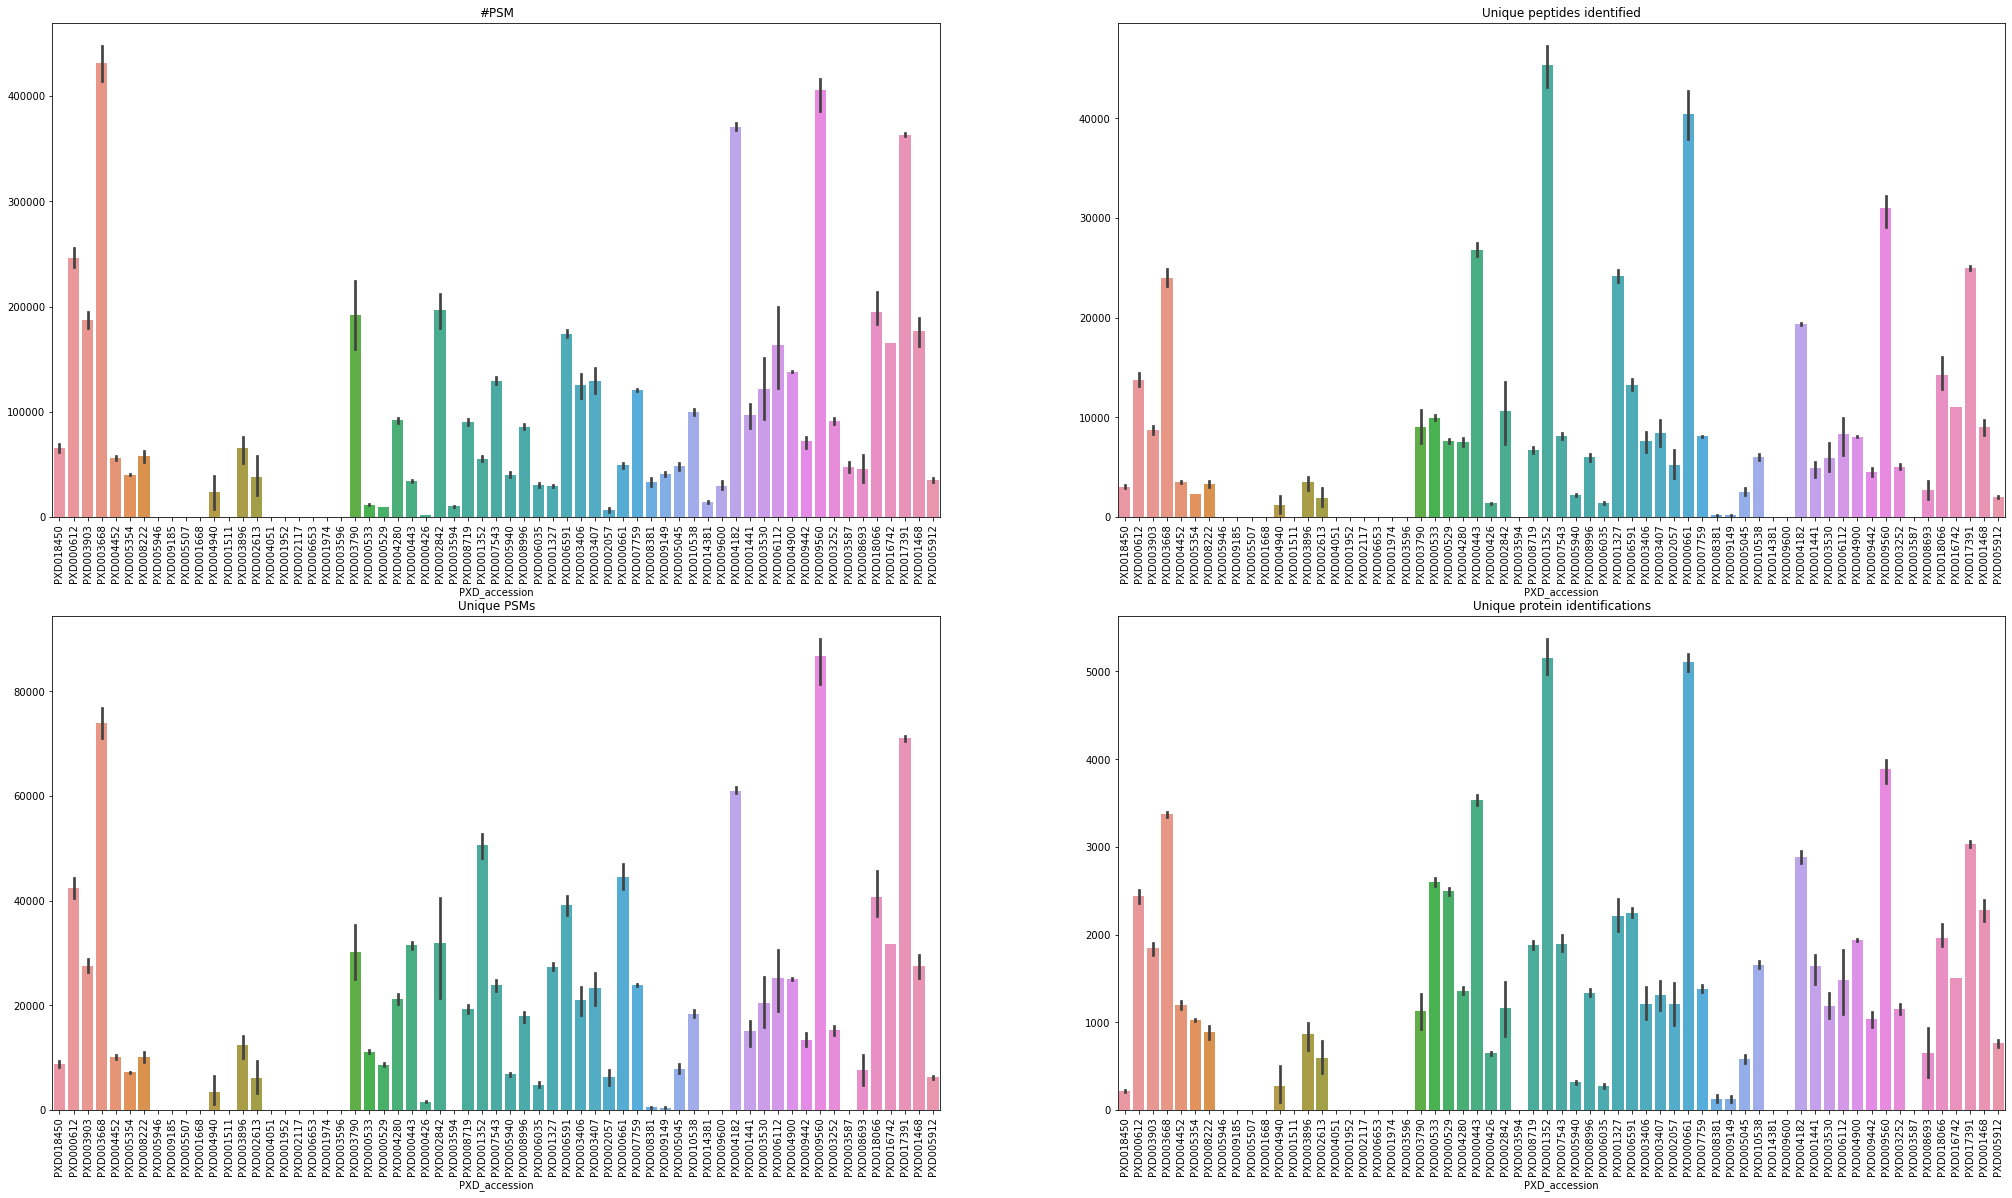

In [50]:
fig, ax = plt.subplots(2,2, figsize = (35,20))

for axi in ax.reshape(-1):
    axi.set_xticklabels(axi.get_xticks(), rotation = 90)

ax[0,0].set_title("#PSM")
ax[0,1].set_title("Unique peptides identified")
ax[1,0].set_title("significant PSMs")
ax[1,1].set_title("Unique protein identifications")


sns.barplot(x=subset_all_parsed.PXD_accession, y=subset_all_parsed["all_PSM"].tolist(), ax=ax[0,0])
sns.barplot(x=subset_all_parsed.PXD_accession , y=subset_all_parsed["peptides"].tolist(), ax=ax[0,1])
sns.barplot(x=subset_all_parsed.PXD_accession , y=subset_all_parsed["sign_PSM"].tolist(), ax=ax[1,0])
sns.barplot(x=subset_all_parsed.PXD_accession , y=subset_all_parsed["proteins"].tolist(), ax=ax[1,1])

In [126]:
print(all_parsed[all_parsed.proteins == 0].shape[0])
empty_file_count = all_parsed[all_parsed.proteins == 0]["PXD_accession"].value_counts()
empty_file_count

1446


PXD005946    732
PXD008222    181
PXD001668     96
PXD004452     64
PXD014381     63
PXD004940     39
PXD003594     32
PXD001511     27
PXD009185     27
PXD009149     21
PXD008381     21
PXD005507     18
PXD002117     18
PXD009600     18
PXD001974     16
PXD004051     16
PXD003790     12
PXD003596     12
PXD002613      8
PXD001952      8
PXD003587      6
PXD006653      4
PXD005354      3
PXD008693      2
PXD003896      1
PXD003903      1
Name: PXD_accession, dtype: int64

In [127]:
counting_files = pd.DataFrame(all_parsed.groupby(["PXD_accession"])["filename"].count()).reset_index().rename({0: "PXD_accession", "filename": "files"}, axis = 1)
counting_files["empty"] = counting_files.PXD_accession.apply(lambda x: empty_file_count[x] if x in empty_file_count.index else 0)
counting_files = counting_files.melt(id_vars = "PXD_accession", value_vars = ["files", "empty"], var_name=["counts"])

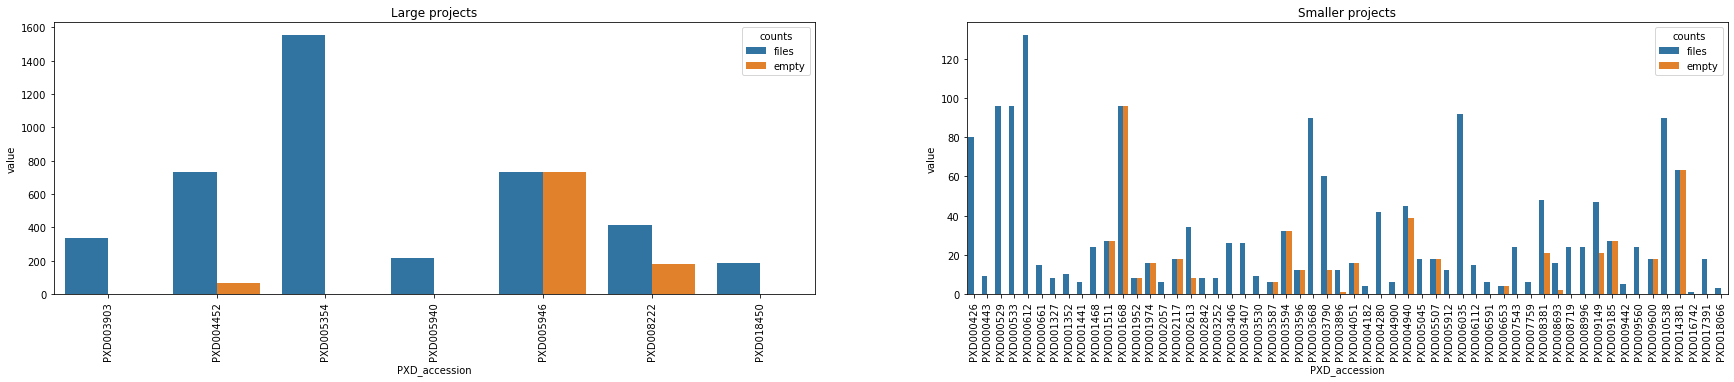

In [128]:
fig, ax = plt.subplots(1,2,figsize=(30,5))
for axi in ax.reshape(-1):
    axi.set_xticklabels(axi.get_xticks(), rotation = 90)

ax[0].set_title("Large projects")
ax[1].set_title("Smaller projects")

sns.barplot(data = counting_files[counting_files.PXD_accession.isin(["PXD004452", "PXD005354", "PXD005946", "PXD008222", "PXD003903", "PXD005940", "PXD018450"])], x="PXD_accession", y="value", hue="counts", ax = ax[0])
sns.barplot(data = counting_files[~counting_files.PXD_accession.isin(["PXD004452", "PXD005354", "PXD005946", "PXD008222", "PXD003903", "PXD005940", "PXD018450"])], x="PXD_accession", y="value", hue="counts", ax = ax[1])

In [129]:
useable_files = all_parsed[ ~(all_parsed.proteins == 0)]

In [133]:
print(f"Total files: {all_parsed.shape[0]}")
print(f"Files that are useable: {useable_files.shape[0]}")
print(f"Empty files: {all_parsed.shape[0]-useable_files.shape[0]}")

Total files: 5860
Files that are useable: 4414
Empty files: 1446


In [148]:
useable_files

,PXD_accession,filename,cell_line,tissue_type,sub_cell,disease,treatment,all_PSM,sign_PSM,peptides,proteins
0,PXD018450,01_1,HepG2,liver,/,hepatoblastoma,/,16740,2115,476,55
1,PXD018450,01_2,HepG2,liver,/,hepatoblastoma,/,17249,2156,475,59
2,PXD018450,02_1,HepG2,liver,/,hepatoblastoma,/,13676,2026,477,63
3,PXD018450,02_2,HepG2,liver,/,hepatoblastoma,/,13336,1965,482,68
4,PXD018450,03_1,HepG2,liver,/,hepatoblastoma,/,25184,3373,956,125
...,...,...,...,...,...,...,...,...,...,...,...
5855,PXD005354,01251_F01_P013026_S00_N06_R1,CRC,colon,/,colorectal cancer,/,33933,6647,2151,1086
5856,PXD005354,01251_F02_P013026_S00_N14_R1,CRC,colon,/,colorectal cancer,/,35306,7113,2252,1042
5857,PXD005354,01251_F03_P013026_S00_N22_R1,CRC,colon,/,colorectal cancer,/,24763,5204,1629,759
5858,PXD005354,01251_F04_P013027_S00_N06_R2,CRC,colon,/,colorectal cancer,/,40653,7525,2383,1092


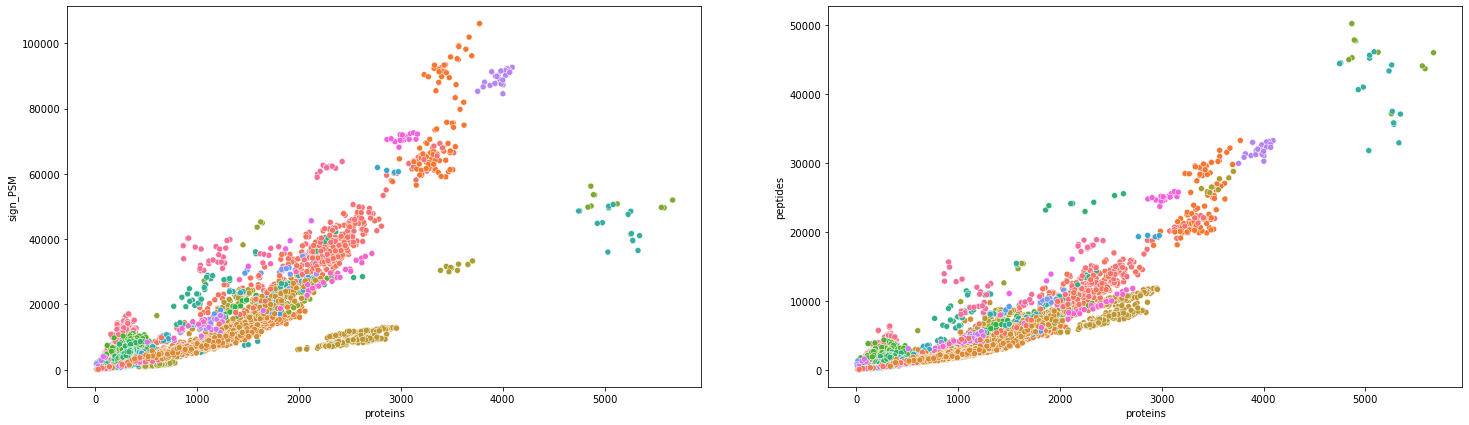

In [154]:
fig, ax = plt.subplots(1,2, figsize =(25,7))

sns.scatterplot(x=useable_files.proteins, y=useable_files.sign_PSM, hue = useable_files.PXD_accession, legend = False, ax = ax[0])
sns.scatterplot(x=useable_files.proteins, y=useable_files.peptides, hue = useable_files.PXD_accession, legend = False, ax = ax[1])

In [155]:
# There seems to be 2 outlier projects. These identify many protiens with only a few PSMs. 
# This means a lot of of the spectra match a more diverse set of peptides which in turn indicate many more proteins compared to the other projects.
# This could indicate that many of the protein identifications will be based on very few peptide identifications.

useable_files[useable_files.proteins > 4500].PXD_accession.unique()

array(['PXD001352', 'PXD000661'], dtype=object)

---
---

In [3]:
meta = pd.read_csv("../Metadata/unified_metadata.csv", index_col="Unnamed: 0")

In [9]:
pooled_nsaf = pd.read_hdf("../Atlas_creation/proteome_nsaf_pooled_3.h5")
pooled_nsaf = pooled_nsaf.pivot(index="assay_id", columns="uniprot_id", values="NSAF")

In [11]:
pooled_nsaf.shape

(621, 14507)

In [14]:
meta

,assay_id,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession,all_PSM,sign_PSM,peptides,proteins,experiment_type,instrument,pmid,pool_id
0,30960,1815,3B10-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,NaN,PXD000533,11014,10578,9705,2401,in-solution,Q-exactive,24328083,1
1,30961,1815,3B10-2,545,Hep3B,hepatocellular carcinoma,/,liver,/,NaN,PXD000533,11530,11036,10104,2449,in-solution,Q-exactive,24328083,2
2,30962,1815,3B1-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,NaN,PXD000533,11558,10874,9947,2620,in-solution,Q-exactive,24328083,1
3,30963,1815,3B11-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,NaN,PXD000533,11821,11205,9940,2542,in-solution,Q-exactive,24328083,1
4,30964,1815,3B11-2,545,Hep3B,hepatocellular carcinoma,/,liver,/,NaN,PXD000533,11704,11014,9757,2449,in-solution,Q-exactive,24328083,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4317,36435,1872,01481_G02_P015041_S00_N15_R1,636,CRC,colorectal cancer,/,colon,/,NaN,PXD005354,42831,8512,2790,1239,in-solution,LTQ Orbitrap Velos,29101300,65
4318,36436,1872,01481_G03_P015041_S00_N23_R1,636,CRC,colorectal cancer,/,colon,/,NaN,PXD005354,23567,4960,1663,663,in-solution,LTQ Orbitrap Velos,29101300,65
4319,36437,1872,01481_H01_P015041_S00_N08_R1,636,CRC,colorectal cancer,/,colon,/,NaN,PXD005354,52524,9375,2980,1296,in-solution,LTQ Orbitrap Velos,29101300,65
4320,36438,1872,01481_H02_P015041_S00_N16_R1,636,CRC,colorectal cancer,/,colon,/,NaN,PXD005354,40851,8223,2626,1135,in-solution,LTQ Orbitrap Velos,29101300,65
